## Сравнение GRU и LSTM моделей

### Подключение библиотек

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Input
from tensorflow.keras.optimizers import Adam

import sys
import os
sys.path.append(os.path.abspath('..'))
from helpful_functions import train_val_test_split, \
                              create_sequences,\
                              denormalize, \
                              train_and_evaluate_model

## 1. Загрузка данных

In [6]:
file_path = '../dataset/preprocessed_data.csv'
df = pd.read_csv(file_path)

df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df.sort_index(inplace=True)

target_feature = 'Global_active_power'
test_ratio = 0.10
val_ratio = 0.10

train_data, val_data, test_data = train_val_test_split(df, val_ratio, test_ratio)

scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
val_scaled = scaler.transform(val_data)
test_scaled = scaler.transform(test_data)

target_idx = df.columns.get_loc(target_feature)

features_count = train_data.shape[1]

## 2. Обучение моделей

In [7]:
learning_rates = [0.1, 0.01, 0.001]
window_sizes = [10, 30, 60]
results = []

for window_size in window_sizes:
    X_train, y_train = create_sequences(train_scaled, target_idx, window_size)
    X_val, y_val = create_sequences(val_scaled, target_idx, window_size)
    X_test, y_test = create_sequences(test_scaled, target_idx, window_size)

    for lr in learning_rates:
        print(f"\nTraining GRU | learning_rate = {lr} | window_size = {window_size}")
        gru_model = Sequential([
            Input(shape=(window_size, features_count)),
            GRU(50, activation='tanh'),
            Dense(1)
        ])
        result_gru = train_and_evaluate_model(
            gru_model, 'GRU', X_train, y_train, X_val, y_val, X_test, y_test,
            lr, window_size, scaler, target_feature, df.columns
        )
        results.append(result_gru)


Training GRU | learning_rate = 0.1 | window_size = 10
GRU | val_loss: 0.0043 | MSE: 0.5208

Training GRU | learning_rate = 0.01 | window_size = 10
GRU | val_loss: 0.0004 | MSE: 0.0448

Training GRU | learning_rate = 0.001 | window_size = 10
GRU | val_loss: 0.0004 | MSE: 0.0435

Training GRU | learning_rate = 0.1 | window_size = 30
GRU | val_loss: 0.0013 | MSE: 0.1530

Training GRU | learning_rate = 0.01 | window_size = 30
GRU | val_loss: 0.0032 | MSE: 0.3952

Training GRU | learning_rate = 0.001 | window_size = 30
GRU | val_loss: 0.0004 | MSE: 0.0433

Training GRU | learning_rate = 0.1 | window_size = 60
GRU | val_loss: 0.0014 | MSE: 0.1734

Training GRU | learning_rate = 0.01 | window_size = 60
GRU | val_loss: 0.0004 | MSE: 0.0509

Training GRU | learning_rate = 0.001 | window_size = 60
GRU | val_loss: 0.0004 | MSE: 0.0439


## 3. Сравнение результатов

In [8]:
results_df = pd.DataFrame(results)
print(results_df.sort_values(by=['mse_val_dn']))

  model_type  learning_rate  window_size  train_loss  val_loss  mse_val_dn  \
5        GRU          0.001           30    0.000495  0.000355    0.043256   
2        GRU          0.001           10    0.000501  0.000356    0.043489   
8        GRU          0.001           60    0.000498  0.000360    0.043868   
1        GRU          0.010           10    0.000474  0.000368    0.044843   
7        GRU          0.010           60    0.000666  0.000417    0.050896   
3        GRU          0.100           30    0.006674  0.001254    0.153020   
6        GRU          0.100           60    0.001550  0.001422    0.173444   
4        GRU          0.010           30    0.002065  0.003239    0.395150   
0        GRU          0.100           10    0.003963  0.004268    0.520797   

   mse_test_dn  
5     0.036851  
2     0.036800  
8     0.037044  
1     0.037564  
7     0.043406  
3     0.141514  
6     0.167168  
4     0.376236  
0     0.524920  


## 4. Нахождение лучших результатов для каждой модели

In [9]:
results_df = pd.DataFrame(results)

best_gru = results_df[results_df['model_type'] == 'GRU'].nsmallest(1, 'mse_val_dn').iloc[0]

print("\nЛучшая GRU (по валидации):")
print(best_gru[['model_type', 'learning_rate', 'window_size', 'mse_val_dn', 'mse_test_dn']])


Лучшая GRU (по валидации):
model_type            GRU
learning_rate       0.001
window_size            30
mse_val_dn       0.043256
mse_test_dn      0.036851
Name: 5, dtype: object


## 5. Заново получаем предсказания этих моделей

In [10]:
X_train_gru, y_train_gru = create_sequences(train_scaled, target_idx, best_gru['window_size'])
X_val_gru, y_val_gru = create_sequences(val_scaled, target_idx, best_gru['window_size'])

gru_model = Sequential([
    Input(shape=(window_size, features_count)),
    GRU(50, activation='tanh'),
    Dense(1)
])
gru_model.compile(optimizer=Adam(learning_rate=best_gru['learning_rate']), loss='mse')
gru_model.fit(X_train_gru, y_train_gru, epochs=5, batch_size=256, validation_data=(X_val_gru, y_val_gru), verbose=0)


### Сохраняем модель

In [16]:
# from tensorflow.keras.models import load_model
# gru_model = load_model('../models/best_gru_model.keras')

gru_model.save('../models/best_gru_model.keras')

### Подключение LSTM модели

In [11]:
from tensorflow.keras.models import load_model
lstm_model = load_model('../models/best_lstm_model.keras')
best_lstm_window_size = 30

X_train_lstm, y_train_lstm = create_sequences(train_scaled, target_idx, best_lstm_window_size)
X_val_lstm, y_val_lstm = create_sequences(val_scaled, target_idx, best_lstm_window_size)

## 6. Делаем предсказания

In [12]:
y_pred_gru = gru_model.predict(X_val_gru, verbose=0)
y_pred_gru_dn = denormalize(scaler, y_pred_gru, target_feature, df.columns)
y_true_val_dn = denormalize(scaler, y_val_gru.reshape(-1, 1), target_feature, df.columns)

y_pred_lstm = lstm_model.predict(X_val_lstm, verbose=0)
y_pred_lstm_dn = denormalize(scaler, y_pred_lstm, target_feature, df.columns)

## 7. Построение графиков моделей на одном window size 

6485/6485 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step
6485/6485 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


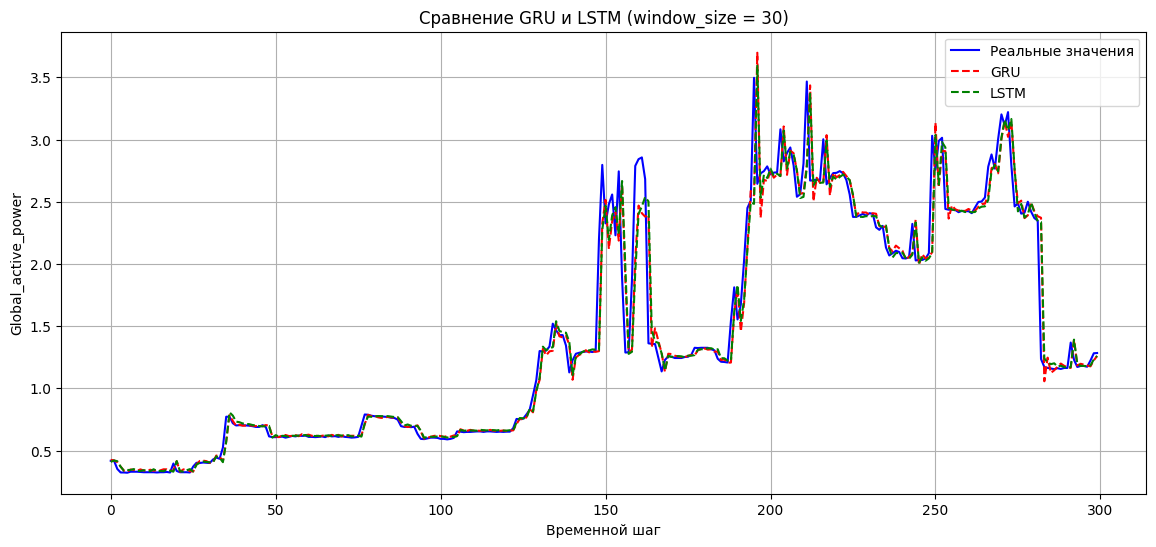

In [13]:
common_window_size = min(best_gru['window_size'], best_lstm_window_size)

X_val_common, y_val_common = create_sequences(val_scaled, target_idx, common_window_size)

y_pred_gru_common = gru_model.predict(X_val_common)
y_pred_lstm_common = lstm_model.predict(X_val_common)

y_pred_gru_dn = denormalize(scaler, y_pred_gru_common, target_feature, df.columns)
y_pred_lstm_dn = denormalize(scaler, y_pred_lstm_common, target_feature, df.columns)
y_true_val_dn = denormalize(scaler, y_val_common.reshape(-1, 1), target_feature, df.columns)

plt.figure(figsize=(14, 6))
plt.plot(y_true_val_dn[:300], label='Реальные значения', color='blue')
plt.plot(y_pred_gru_dn[:300], label='GRU', color='red', linestyle='--')
plt.plot(y_pred_lstm_dn[:300], label='LSTM', color='green', linestyle='--')

plt.title(f"Сравнение GRU и LSTM (window_size = {common_window_size})")
plt.xlabel("Временной шаг")
plt.ylabel("Global_active_power")
plt.legend()
plt.grid(True)
plt.show()

## 8. Оценка моделей на тесте

In [15]:
X_test_gru, y_test_gru = create_sequences(test_scaled, target_idx, best_gru['window_size'])
X_test_lstm, y_test_lstm = create_sequences(test_scaled, target_idx, best_lstm_window_size)


print("GRU model test loss:")
gru_loss = gru_model.evaluate(X_test_gru, y_test_gru)
print(f"Test Loss: {gru_loss:.6f}")

print("\nLSTM model test loss:")
lstm_loss = lstm_model.evaluate(X_test_lstm, y_test_lstm)
print(f"Test Loss: {lstm_loss:.6f}")

GRU model test loss:
6485/6485 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 2.4067e-04
Test Loss: 0.000302

LSTM model test loss:
6485/6485 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 2.2812e-04
Test Loss: 0.000283
